<a href="https://colab.research.google.com/github/vsstejas777/Image-segmentation-of-OD-OC-using-Keras/blob/main/unet_segmentation_for_fundus_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
import zipfile
import cv2
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import albumentations as A
import random
from tensorflow.keras.layers import Input,Conv2D,Lambda,Dropout,MaxPooling2D,Conv2DTranspose,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import custom_object_scope
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
img_paths=['/content/drive/MyDrive/glaucoma-datasets/G1020/Images_Cropped/img/*.jpg',
           '/content/drive/MyDrive/glaucoma-datasets/ORIGA/Images_Cropped/*',
           '/content/drive/MyDrive/glaucoma-datasets/REFUGE/train/Images_Cropped/*']


mask_paths=['/content/drive/MyDrive/glaucoma-datasets/G1020/Masks_Cropped/img/*.png',
           '/content/drive/MyDrive/glaucoma-datasets/ORIGA/Masks_Cropped/*',
           '/content/drive/MyDrive/glaucoma-datasets/REFUGE/train/Masks_Cropped/*']

In [21]:


transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
])
def load_and_transform(img_paths, mask_paths):
    transformed_images = []
    transformed_masks = []


    for img_path, mask_path in zip(img_paths, mask_paths):

        images = glob.glob(img_path)
        masks = glob.glob(mask_path)

        for image_path, mask_path in zip(images, masks):

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            transformed=transform(image=image)
            image=transformed['image']


            image = cv2.resize(image ,(128,128))
            image=image/255
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask= cv2.resize(mask,(128,128))

            if(random.random()<0.5):
              mask=cv2.flip(mask,0)
              image=cv2.flip(image,0)


            if(random.random()<0.5):
               mask=cv2.flip(mask,1)
               image=cv2.flip(image,1)

            mask=np.expand_dims(mask,axis=-1)
            transformed_images.append(image)
            transformed_masks.append(mask)

    transformed_images = np.array(transformed_images)
    transformed_masks = np.array(transformed_masks,dtype='float32')

    return transformed_images, transformed_masks

In [22]:
images,masks=load_and_transform(img_paths,mask_paths)

In [23]:
print(f"Shape of images: {images.shape}")
print(f"Shape of Masks: {masks.shape}")

Shape of images: (2070, 128, 128, 3)
Shape of Masks: (2070, 128, 128, 1)


In [24]:
le=LabelEncoder()
masks_flat = masks.reshape(-1, 1)
masks_flat_enc = le.fit_transform(masks_flat)
masks_reenc = masks_flat_enc.reshape(2070,128,128)
masks_categorical = to_categorical(masks_reenc, num_classes=3)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
print(f"Shape of Categorical_Masks: {masks_categorical.shape}")

Shape of Categorical_Masks: (2070, 128, 128, 3)


In [26]:
x_train, x_test, y_train, y_test = train_test_split(images, masks_categorical, test_size=0.20)

In [27]:
print(f"Shape of Training images: {x_train.shape}")
print(f"Shape of Training Masks: {y_train.shape}")
print(f"Shape of Test images: {x_test.shape}")
print(f"Shape of Test Masks: {y_test.shape}")

Shape of Training images: (1656, 128, 128, 3)
Shape of Training Masks: (1656, 128, 128, 3)
Shape of Test images: (414, 128, 128, 3)
Shape of Test Masks: (414, 128, 128, 3)


In [28]:
def dice_coefficient(y_true, y_pred, epsilon=1e-7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    dice_score = (2. * intersection + epsilon) / (union + epsilon)
    return dice_score

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

In [40]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

num_classes=3;

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = BatchNormalization()(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = BatchNormalization()(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = BatchNormalization()(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3 = BatchNormalization()(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = BatchNormalization()(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = BatchNormalization()(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = BatchNormalization()(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = BatchNormalization()(c6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = BatchNormalization()(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = BatchNormalization()(c7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = BatchNormalization()(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = BatchNormalization()(c8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = BatchNormalization()(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = BatchNormalization()(c9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = BatchNormalization()(c9)

outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

with custom_object_scope({'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient}):
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coefficient])
    model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda_2 (Lambda)           (None, 128, 128, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv2d_38 (Conv2D)          (None, 128, 128, 16)         448       ['lambda_2[0][0]']            
                                                                                                  
 batch_normalization_36 (Ba  (None, 128, 128, 16)         64        ['conv2d_38[0][0]']           
 tchNormalization)                                                                          

In [30]:
callback = EarlyStopping( patience=4, monitor="val_loss",restore_best_weights=True)

In [31]:
result = model.fit(
    x_train, y_train, batch_size=16, epochs=25, validation_data=(x_test, y_test), callbacks=[callback],verbose=1
)

Epoch 1/25
104/104 [==============================] - 19s 76ms/step - loss: 0.2908 - accuracy: 0.7330 - dice_coefficient: 0.7097 - val_loss: 0.8090 - val_accuracy: 0.1888 - val_dice_coefficient: 0.1909
Epoch 2/25
104/104 [==============================] - 7s 69ms/step - loss: 0.1985 - accuracy: 0.8053 - dice_coefficient: 0.8017 - val_loss: 0.4795 - val_accuracy: 0.5207 - val_dice_coefficient: 0.5207
Epoch 3/25
104/104 [==============================] - 7s 71ms/step - loss: 0.1901 - accuracy: 0.8117 - dice_coefficient: 0.8099 - val_loss: 0.4475 - val_accuracy: 0.5511 - val_dice_coefficient: 0.5527
Epoch 4/25
104/104 [==============================] - 7s 68ms/step - loss: 0.1850 - accuracy: 0.8160 - dice_coefficient: 0.8149 - val_loss: 0.7494 - val_accuracy: 0.2495 - val_dice_coefficient: 0.2505
Epoch 5/25
104/104 [==============================] - 7s 70ms/step - loss: 0.1813 - accuracy: 0.8195 - dice_coefficient: 0.8186 - val_loss: 0.4414 - val_accuracy: 0.5583 - val_dice_coefficient: 0

13/13 [==============================] - 1s 43ms/step


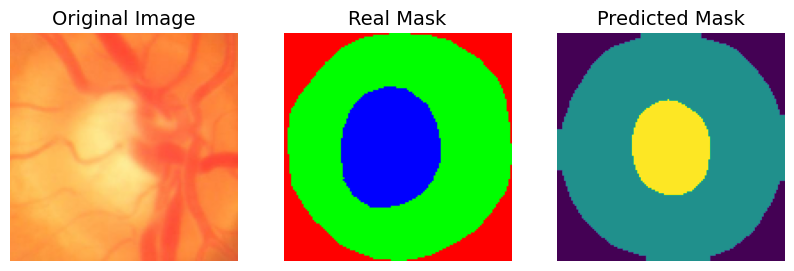

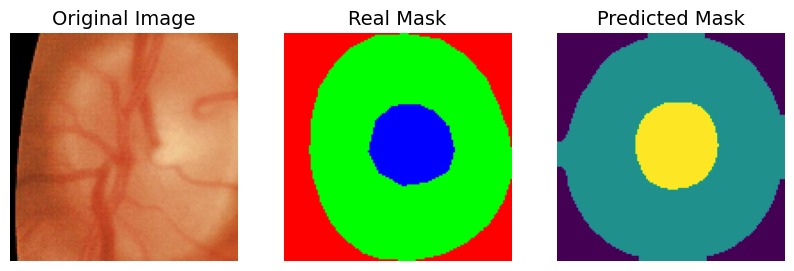

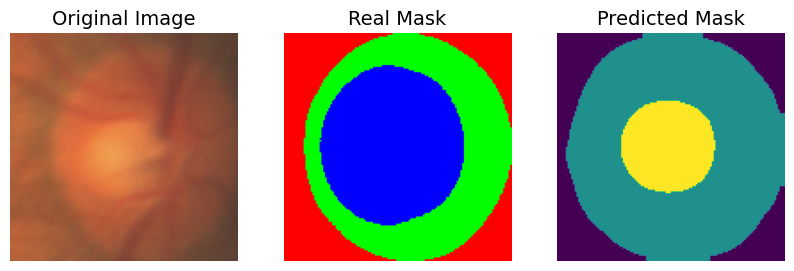

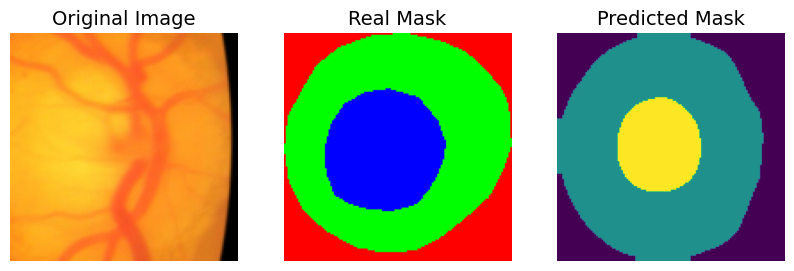

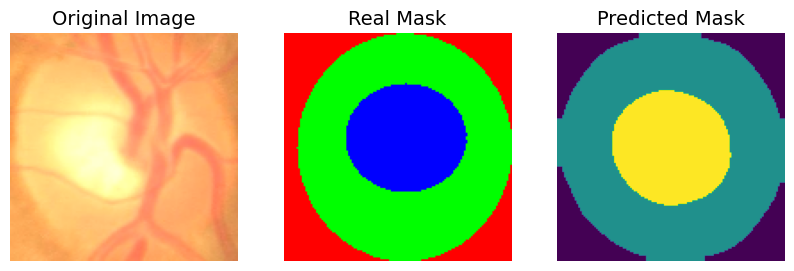

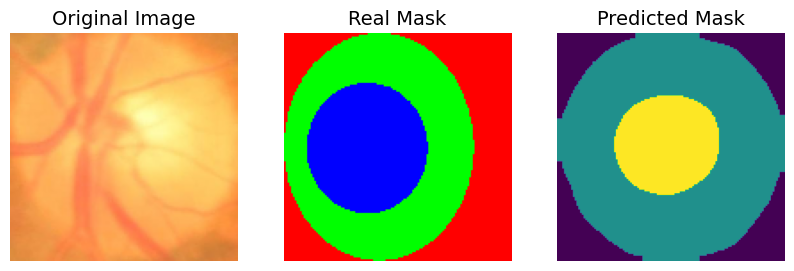

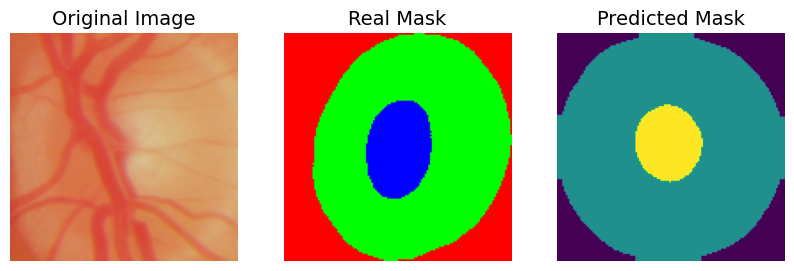

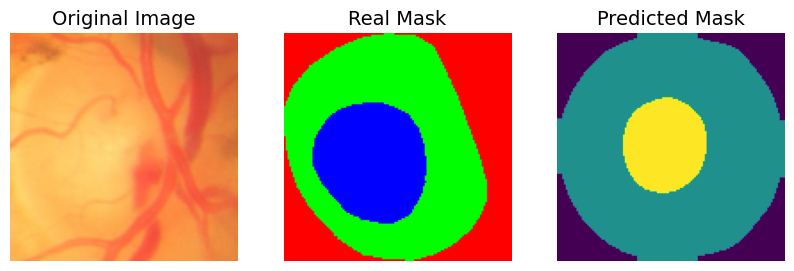

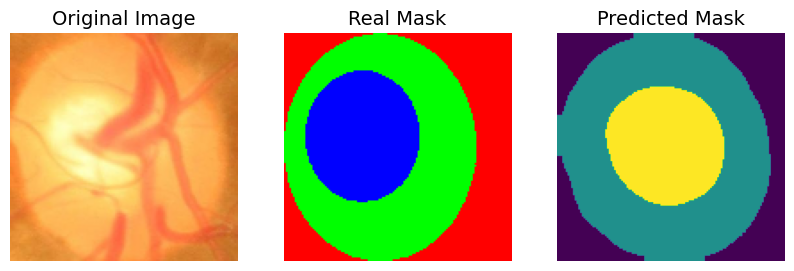

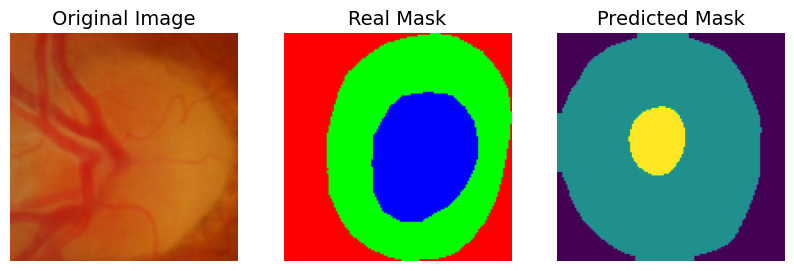

In [39]:
def apply_morphological_close(image, kernel_size=(5,5)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

predictions = model.predict(x_test)
predicted_masks = (np.argmax(predictions, axis=-1)).astype(np.uint8)

for i in range(10,20):
    test_image = x_test[i, :, :, :]
    real_mask = y_test[i, :, :,:]
    predicted_mask = predicted_masks[i, :, :]

    predicted_mask = apply_morphological_close(predicted_mask)


    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title('Original Image', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(real_mask)
    plt.title('Real Mask', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask', fontsize=14)
    plt.axis('off')

    plt.show()

In [33]:
model.save('/content/drive/MyDrive/unet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
enc_masks = np.argmax(y_test, axis=-1)



enc_masks_flat=enc_masks.flatten()
predicted_masks_flat=predicted_masks.flatten()


In [35]:
print(f"Shape of images: {enc_masks_flat.shape}")
print(f"Shape of Masks: {predicted_masks_flat.shape}")

Shape of images: (6782976,)
Shape of Masks: (6782976,)


In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy=accuracy_score(enc_masks_flat,predicted_masks_flat)
print(accuracy)
conf_matrix = confusion_matrix(enc_masks_flat,predicted_masks_flat)
print(conf_matrix)

0.8199045669629378
[[1561954  387229    4385]
 [ 166979 3205341  226054]
 [    247  436689  794098]]


In [37]:
evals=model.evaluate(x_test,y_test,batch_size=16,verbose=1)

26/26 [==============================] - 0s 17ms/step - loss: 0.1803 - accuracy: 0.8199 - dice_coefficient: 0.8198


In [38]:
np.save('/content/drive/MyDrive/unet_xtest.npy',x_test)
np.save('/content/drive/My Drive/unet_ytest.npy',y_test)
np.save('/content/drive/My Drive/unet_xtrain.npy',x_train)
np.save('/content/drive/My Drive/unet_ytrain.npy',y_train)